## Import Dependencies and Setting the Enviroment

In [1]:
import tensorflow as tf
#from tensorflow.keras import layers,models, optimizers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

import numpy as np
import matplotlib.pyplot as plt  
import os

In [2]:
# Define the path to your desired working directory
new_working_directory = "C:\\Users\\muhdi\\UM\\SEM 7\\WID 3009 AI Game Programming\\Assignment\\pixel art GANs"

# Change the current working directory
os.chdir(new_working_directory)

print("The current working directory:", os.getcwd())

The current working directory: C:\Users\muhdi\UM\SEM 7\WID 3009 AI Game Programming\Assignment\pixel art GANs


## Visualize Data

In [3]:
train_data_dir = 'GAN dataset/'

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(16, 16),
    batch_size=16,
    class_mode=None, 
    color_mode='rgb'
)


Found 150 images belonging to 3 classes.


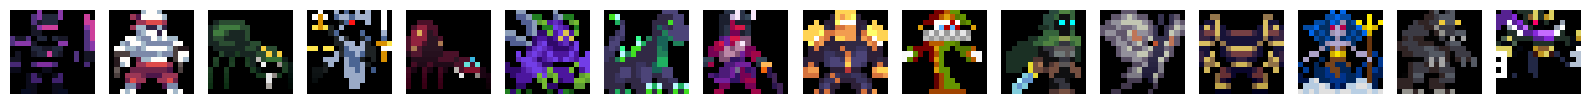

In [5]:
# Fetch a batch of images and labels from the generator
images= next(train_generator)

# Display the images
plt.figure(figsize=(16, 16))
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(images[i])
    plt.axis('off')  # Hide axis labels
    #plt.title(f"Class: {labels[i]}")
plt.tight_layout()
plt.show()


## Generator and Discriminator Class

In [3]:
def Generator():
    model = Sequential()

    model.add(Dense(4*4*256, input_dim=100))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((4, 4, 256)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(256, 3, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(256, 3, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(256, 3, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(256, 3, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to three channels (RGB)
    model.add(Conv2D(3, 3, padding='same', activation='tanh'))

    return model



In [7]:
generator = Generator()
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 8, 8, 256)         0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         590080    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                       

1/1 [==============================] - 0s 353ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


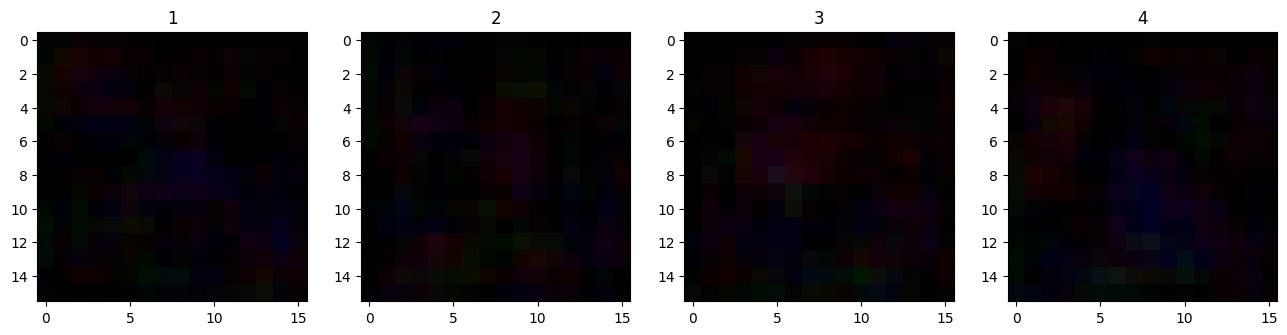

In [8]:
img = generator.predict(np.random.randn(4,100,1))

fig, ax = plt.subplots(ncols=4, figsize=(16,16))

for idx, img in enumerate(img): 
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx+1)

In [4]:
def Discriminator():
    model = Sequential()
    
    model.add(Conv2D(32, 5, input_shape=(16, 16, 3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256, 3))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [10]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 12, 12, 32)        2432      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12, 12, 32)        0         
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 128)        

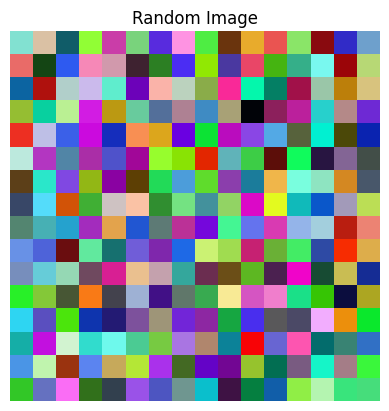

1/1 [==============================] - 0s 177ms/step


array([[0.49596497]], dtype=float32)

In [11]:
random_image = np.random.random((16,16,3))
plt.imshow(random_image)
plt.axis('off')
plt.title('Random Image')
plt.show()
random_image = random_image.reshape(1, 16,16,3)
discriminator.predict(random_image)

## Training Loop

In [5]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [6]:
class PixelArtGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((100, 100, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((100,100,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [14]:
gan = PixelArtGAN(generator, discriminator)
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [15]:
# Adjust callback for handling 16x16x3 images
class ImageGeneratorCallback(Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal((self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors, training=False)
        generated_images = (generated_images + 1) * 127.5  # Scale images from [-1, 1] to [0, 255]
        generated_images = tf.reshape(generated_images, [-1, 16, 16, 3])

        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(f'generated_image_{epoch}_{i}.png')


In [ ]:
# Train the model
epochs = 3000 
history = gan.fit(train_generator, epochs=epochs, callbacks=[ImageGeneratorCallback()])

## Save the Weights

In [ ]:
# Save Generator and Discriminator weights
generator.save_weights('generator_weights.h5')
discriminator.save_weights('discriminator_weights.h5')


1/1 [==============================] - 0s 64ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 61ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 66ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 66ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


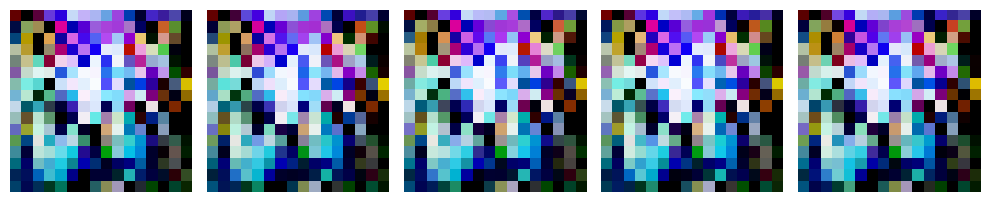

In [ ]:
gen = Generator()

# Load the saved weights
gen.load_weights('generator_weights.h5')

# Generate a new image using the loaded Generator

num_images = 5  # Define the number of images to generate and display

plt.figure(figsize=(10, 6))  # Adjust figure size as needed

for i in range(num_images):
    # Generate random noise as input
    noise = np.random.normal(np.random.randn(1,100,1))
    #np.random.randn(4,100,1)

    # Generate image
    generated_image = generator.predict(noise)

    # Display the generated image
    plt.subplot(1, num_images, i + 1)
    plt.imshow(generated_image[0])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Resume training

In [ ]:
# Load the weights for the discriminator
discriminator = Discriminator
discriminator.load_weights('discriminator_weights.h5')

# Load the weights for the generator
generator = Generator()
generator.load_weights('generator_weights.h5')

g_opt = Adam(learning_rate=0.001) 
d_opt = Adam(learning_rate=0.0001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

gan = PixelArtGAN(generator, discriminator)
gan.compile(g_opt, d_opt, g_loss, d_loss)

epochs = 1000 
history = gan.fit(train_generator, epochs=epochs, callbacks=[ImageGeneratorCallback()])